In [1]:
import pandas as pd
import logging
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
import operator
import os
from sklearn.cross_validation import train_test_split
from random import shuffle
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import StratifiedKFold
import tqdm
%matplotlib inline

#PLOT CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import itertools
import pickle
#matrix inverse
from numpy.linalg import inv
import jj_basic_fn as JJ
from hyperparams import Hyperparams as hp
from patient import patient
import prep
import plot_funcs
import modules
#default size of the graph
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_colwidth', -1)

n_classifier = 7

col_rs = hp.col_rs
col_es = hp.col_es
col_le = hp.col_le



/Users/hp/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/hp/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [39]:
#[p241,p226] = modules.build_patients(-2, 90)
#pats = [p241,p226]
#p241 = modules.build_patients(241, 90)
#p231 = modules.build_patients(231, 90)
p231, p222_1, p222_2, p229 = modules.build_patients(-1,90)
# p231, p222_1, p222_2, p229 = modules.build_patients()
# pat_list = [p231, p222_1, p222_2, p229]
# for pat in pat_list:
#     JJ.save_object(pat, '../patients/' + pat.id +'.p')


/Users/hp/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/hp/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


ValueError: too many values to unpack (expected 4)

In [37]:
p241.epoch_label_dict

{0: True,
 1: True,
 2: True,
 3: True,
 4: False,
 5: True,
 6: False,
 7: False,
 8: False,
 9: False}

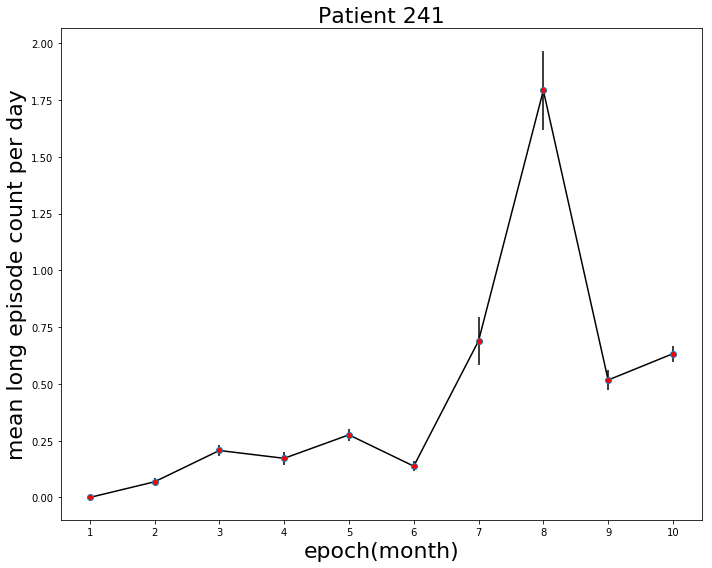

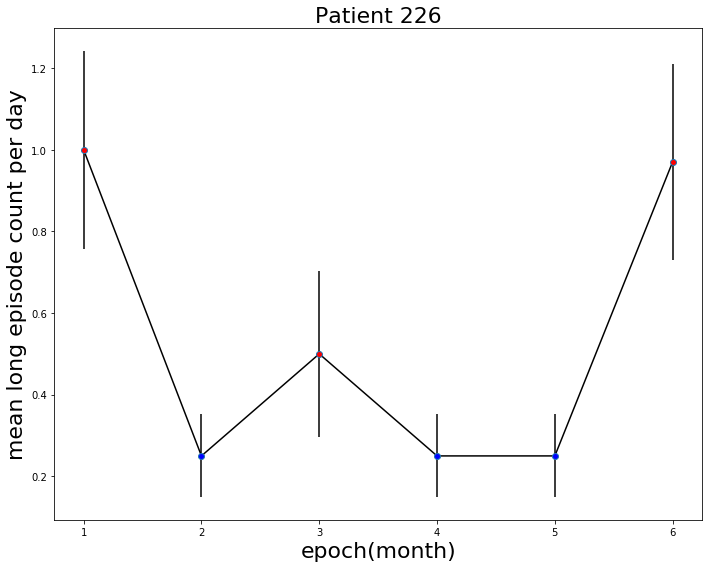

(531, 38)
(86, 38)


In [38]:
plot_funcs.plot_epoch_mean(pats, if_save = 0)
print(p241.features.shape)
print(p226.features.shape)

In [11]:
def parameter_tuning(pat, X_train, X_test, y_train, y_test, classifier, C_range_num = 30, if_save = 0,
                     nfold = 10, if_show = 1):
    #defs is a dictionary to initiate classifier with the parameters that don't need to be tuned
    defs = {}
    defs['classifier'] = classifier
    
    num_instances, num_features = X_train.shape[0], X_train.shape[1]
    n_fold = 10

    skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
    CV = skf.split(np.zeros(len(y_train)), y_train)
    

    if classifier==1:
        clf_name = 'Logistic Regression'
        defs['class_weight'] = 'balanced'
        defs['max_iter'] = 200
        C_range = 10 ** np.random.uniform(-2, 1, size = C_range_num)
        tuned_params = dict(penalty=['l1','l2'], C=C_range)
    elif classifier == 2: 
        clf_name = 'SVM'
        defs['class_weight'] = 'balanced'
        kernel_list = ['rbf']    
        gamma_list = [2**i*1/num_features for i in range(1)]
        #degree_list = [2,3,4,5]
        C_range = 10 ** np.random.uniform(-3, 1, size = C_range_num)
        tuned_params = dict(kernel=kernel_list,gamma = gamma_list, C=C_range)

    elif classifier==3:
        clf_name = 'Gaussian Naive Bayes classifier'
        prr = np.ones(2) * (1.0/2)
        defs['priors'] = prr
        clf_try = JJ.clf_list(defs)
        clf_try.fit(X_train, y_train)
        pat.estimator[classifier] = clf_try
        return

    elif classifier==4:
        clf_name = 'Linear Discriminant Analysis'
        prr = np.ones(2) * (1.0/2)
        defs['solver'] = 'eigen'  # 'svd', 'lsqr', 'eigen'
        defs['shrinkage'] = 'auto'
        defs['priors'] = prr
        clf_try = JJ.clf_list(defs)
        clf_try.fit(X_train, y_train)
        pat.estimator[classifier] = clf_try
        return
    elif classifier == 5:
        clf_name = 'decision tree'
        mss_list = [5,10,20,40,60]
        criterion_list = ['entropy']
        max_depth_list = [3,4,5,8,12,18]
        clf_name = 'decision tree'
        tuned_params = dict(criterion=criterion_list, min_samples_split=mss_list, max_depth = max_depth_list)
    elif classifier == 6:
        clf_name = 'random forest'
        defs['n_estimators'] = 600
        mss_list = [20,25,30,40]
        criterion_list = ['entropy']
        max_depth_list = [12,13,14,15,16]
        max_features_list = ['auto']
        tuned_params = dict(criterion=criterion_list, min_samples_split=mss_list, max_depth = max_depth_list, max_features = max_features_list)
    elif classifier == 7:
        clf_name = 'gradient boosting'
        defs['n_estimators'] = 2000
        max_depth_list, subsample_list, learning_rate_list, min_samples_leaf_list = [1,2,3], [0.1,0.15,0.2, 0.3, 0.4], [0.02, 0.01,0.005], [10,20,30] 
        #params = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.5,
        #  'learning_rate': 0.01, 'min_samples_leaf': 10, 'random_state': 3}
        tuned_params = dict(max_depth=max_depth_list, subsample = subsample_list,learning_rate = learning_rate_list, min_samples_leaf= min_samples_leaf_list)
    
        
    clf_try = JJ.clf_list(defs)
    
    clf_grid = GridSearchCV(clf_try,
                            param_grid=tuned_params,
                            cv=CV,
                            scoring = 'roc_auc',
                            verbose=1,
                           return_train_score = True)
    clf_grid.fit(X_train, y_train)
    print('Best score for validations set: {}'.format(clf_grid.best_score_))
    print('Best parameters: {}'.format(clf_grid.best_params_))

    clf_best = clf_grid.best_estimator_

    y_pred = clf_best.predict(X_test)
    df = pd.DataFrame(clf_grid.cv_results_)
    if if_show:
        JJ.show_result(y_pred, y_test, df, clf_name, if_save = if_save)
    
    if if_save:
        pat.result[classifier] = df
        pat.estimator[classifier] = clf_best
        pat.score[classifier] = clf_grid.best_score_
        pat.params[classifier] = clf_grid.best_params_



In [12]:
# X_train, X_test, y_train, y_test = modules.get_ml_data(p2, if_remove_icd = 1, if_remove_sleep=1, if_remove_le=0, le_class = 1)
# parameter_tuning(p229,X_train, X_test, y_train, y_test,1, C_range_num = 100, 
#                      nfold = 10, if_save = 0, if_show = 1)

In [13]:
def parameter_tuning_all(pat, C_range_num, if_scaler = 1, if_remove_icd = 1, if_remove_sleep=1, if_remove_le = 1, le_class = None, if_save = 1, if_show = 0, if_remove_delta = 1, if_remove_outliers = 0):
    X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_scaler = if_scaler, if_remove_icd = if_remove_icd, if_remove_sleep = if_remove_sleep, if_remove_le = if_remove_le, le_class = le_class, if_remove_delta = if_remove_delta, if_remove_outliers = if_remove_outliers)
    train_para = {}
    train_para['if_scaler'], train_para['if_remove_icd'], train_para['if_remove_sleep'], train_para['if_remove_le'] \
    , train_para['le_class'], train_para['if_remove_delta'], train_para['if_remove_outliers'] = \
    if_scaler, if_remove_icd, if_remove_sleep, if_remove_le, le_class, if_remove_delta, if_remove_outliers
    pat.train_para = train_para
    pat.X_train, pat.X_test, pat.y_train, pat.y_test = X_train, X_test, y_train, y_test
    for classifier_int in tqdm.trange(1,hp.num_classifier + 1):
        parameter_tuning(pat, X_train, X_test, y_train, y_test, C_range_num = C_range_num, classifier = classifier_int, if_save = if_save, if_show = if_show)
    if if_save:
        JJ.save_object(pat, hp.prepath_pat + pat.id +'_trained_124_d_no.p')

In [14]:
parameter_tuning_all(p229, C_range_num = 100, if_save = 1, if_remove_delta = 0, if_remove_outliers = 1)

  0%|          | 0/7 [00:00<?, ?it/s]

Total outliers removed: 45
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   41.1s finished
 14%|█▍        | 1/7 [00:41<04:06, 41.08s/it]

Best score for validations set: 0.7347922429094218
Best parameters: {'C': 0.015908556110534336, 'penalty': 'l2'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   49.3s finished
 29%|██▊       | 2/7 [01:30<03:45, 45.19s/it]

Best score for validations set: 0.762815049937654
Best parameters: {'C': 0.9233040558576882, 'gamma': 0.03571428571428571, 'kernel': 'rbf'}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    4.7s finished
 71%|███████▏  | 5/7 [01:35<00:38, 19.03s/it]

Best score for validations set: 0.6581179378531073
Best parameters: {'max_depth': 5, 'criterion': 'entropy', 'min_samples_split': 40}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  6.3min finished
 86%|████████▌ | 6/7 [07:54<01:19, 79.01s/it]

Best score for validations set: 0.7755809796228378
Best parameters: {'max_depth': 16, 'max_features': 'auto', 'criterion': 'entropy', 'min_samples_split': 20}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 32.7min finished
100%|██████████| 7/7 [40:39<00:00, 348.56s/it]

Best score for validations set: 0.7667237883163356
Best parameters: {'max_depth': 3, 'subsample': 0.4, 'min_samples_leaf': 20, 'learning_rate': 0.005}


In [34]:
parameter_tuning_all(p222_1, C_range_num = 100, if_scaler = 1, 
                     if_remove_icd =1, if_remove_sleep = 0, \
                     le_class = None, if_remove_le = 1, if_save = 1, if_remove_delta = 0)


  0%|          | 0/7 [00:00<?, ?it/s]

Total outliers removed: 19
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   11.3s finished

 14%|█▍        | 1/7 [00:11<01:08, 11.37s/it]

Best score for validations set: 0.6569558463115885
Best parameters: {'penalty': 'l1', 'C': 0.11452649649146483}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   24.0s finished

 29%|██▊       | 2/7 [00:35<01:28, 17.68s/it]

Best score for validations set: 0.6818243795834832
Best parameters: {'C': 0.7218726770046145, 'gamma': 0.034482758620689655, 'kernel': 'rbf'}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.6s finished

 71%|███████▏  | 5/7 [00:39<00:15,  7.81s/it]

Best score for validations set: 0.5929573625185203
Best parameters: {'min_samples_split': 10, 'max_depth': 18, 'criterion': 'entropy'}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.8min finished

 86%|████████▌ | 6/7 [05:25<00:54, 54.31s/it]

Best score for validations set: 0.6586337789885877
Best parameters: {'max_features': 'auto', 'min_samples_split': 20, 'max_depth': 16, 'criterion': 'entropy'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 26.3min finished

100%|██████████| 7/7 [31:43<00:00, 271.99s/it]


Best score for validations set: 0.6554263456224241
Best parameters: {'learning_rate': 0.005, 'subsample': 0.4, 'min_samples_leaf': 20, 'max_depth': 3}


In [35]:
parameter_tuning_all(p222_2, C_range_num = 100, if_scaler = 1, 
                     if_remove_icd =1, if_remove_sleep = 0, \
                     le_class = None, if_remove_le = 1, if_save = 1, if_remove_delta = 0)


  0%|          | 0/7 [00:00<?, ?it/s]

Total outliers removed: 15
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   20.2s finished

 14%|█▍        | 1/7 [00:20<02:01, 20.24s/it]

Best score for validations set: 0.7128689102207476
Best parameters: {'penalty': 'l2', 'C': 0.1815970266749164}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   19.8s finished

 29%|██▊       | 2/7 [00:40<01:40, 20.02s/it]

Best score for validations set: 0.7229768732530186
Best parameters: {'C': 3.0182059233671166, 'gamma': 0.034482758620689655, 'kernel': 'rbf'}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.1s finished

 71%|███████▏  | 5/7 [00:43<00:17,  8.62s/it]

Best score for validations set: 0.6674380358955165
Best parameters: {'min_samples_split': 60, 'max_depth': 8, 'criterion': 'entropy'}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.4min finished

 86%|████████▌ | 6/7 [05:05<00:50, 50.98s/it]

Best score for validations set: 0.7072816041377961
Best parameters: {'max_features': 'auto', 'min_samples_split': 30, 'max_depth': 13, 'criterion': 'entropy'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 23.8min finished

100%|██████████| 7/7 [28:52<00:00, 247.45s/it]


Best score for validations set: 0.7231486632746988
Best parameters: {'learning_rate': 0.005, 'subsample': 0.15, 'min_samples_leaf': 10, 'max_depth': 3}


In [36]:
parameter_tuning_all(p231, C_range_num = 100, if_scaler = 1, 
                     if_remove_icd =1, if_remove_sleep = 0, \
                     le_class = None, if_remove_le = 1, if_save = 1, if_remove_delta = 0)


  0%|          | 0/7 [00:00<?, ?it/s]

Total outliers removed: 21
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   19.9s finished

 14%|█▍        | 1/7 [00:19<01:59, 19.93s/it]

Best score for validations set: 0.8284493782971579
Best parameters: {'penalty': 'l1', 'C': 0.9087943416819215}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   32.6s finished

 29%|██▊       | 2/7 [00:52<02:11, 26.27s/it]

Best score for validations set: 0.8415822340569515
Best parameters: {'C': 3.5588807813816326, 'gamma': 0.034482758620689655, 'kernel': 'rbf'}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.9s finished

 71%|███████▏  | 5/7 [00:56<00:22, 11.28s/it]

Best score for validations set: 0.8027130542877472
Best parameters: {'min_samples_split': 40, 'max_depth': 4, 'criterion': 'entropy'}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  5.1min finished

 86%|████████▌ | 6/7 [06:01<01:00, 60.23s/it]

Best score for validations set: 0.8439371452196451
Best parameters: {'max_features': 'auto', 'min_samples_split': 20, 'max_depth': 13, 'criterion': 'entropy'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 29.1min finished

100%|██████████| 7/7 [35:08<00:00, 301.21s/it]


Best score for validations set: 0.8597971080824425
Best parameters: {'learning_rate': 0.01, 'subsample': 0.3, 'min_samples_leaf': 30, 'max_depth': 1}
